In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob


In [2]:
# initial parameters
epochs = 800
lr = 1e-3
batch_size = 64
img_dims = (128,128,3)

data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob(r'gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)


In [3]:
# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
        
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]


In [4]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)


In [5]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.3,
                         horizontal_flip=True,vertical_flip=True, fill_mode="nearest")


In [6]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(16, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(16, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))


    model.add(Conv2D(32, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(32, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model


In [7]:
# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", 'binary_crossentropy'])


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-03 14:25:45.400310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-03 14:25:45.400425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 42, 42, 16)        0

In [9]:
# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)


Epoch 1/800


2022-05-03 14:25:45.913256: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-03 14:25:46.414573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.6540 - binary_crossentropy: 0.7332

2022-05-03 14:25:50.691486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 5s 104ms/step - loss: 0.7332 - accuracy: 0.6540 - binary_crossentropy: 0.7332 - val_loss: 0.7402 - val_accuracy: 0.5159 - val_binary_crossentropy: 0.7402
Epoch 2/800
30/30 [==============================] - 3s 91ms/step - loss: 0.5587 - accuracy: 0.7400 - binary_crossentropy: 0.5587 - val_loss: 0.9139 - val_accuracy: 0.5159 - val_binary_crossentropy: 0.9139
Epoch 3/800
30/30 [==============================] - 3s 93ms/step - loss: 0.4871 - accuracy: 0.7785 - binary_crossentropy: 0.4871 - val_loss: 0.6933 - val_accuracy: 0.5159 - val_binary_crossentropy: 0.6933
Epoch 4/800
30/30 [==============================] - 3s 91ms/step - loss: 0.4395 - accuracy: 0.8080 - binary_crossentropy: 0.4395 - val_loss: 1.1056 - val_accuracy: 0.5159 - val_binary_crossentropy: 1.1056
Epoch 5/800
30/30 [==============================] - 3s 92ms/step - loss: 0.4417 - accuracy: 0.7964 - binary_crossentropy: 0.4417 - val_loss: 0.8385 - val_accuracy: 0.5159 - val_binary_cr

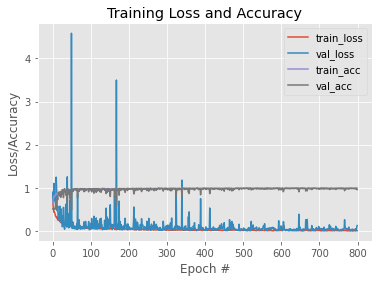

In [10]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")


plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
#plt.savefig('plot.png')

In [11]:
model.evaluate(testX, testY, verbose=1)

11/11 [==============================] - 0s 8ms/step - loss: 0.1295 - accuracy: 0.9625 - binary_crossentropy: 0.1295


[0.1295025795698166, 0.962536096572876, 0.1295025795698166]

In [12]:
import pickle
from datetime import date

pickle.dump(model, open('model.pkl', 'wb'))

2022-05-03 15:03:37.448550: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://3e30d001-5ce7-4047-adab-238b4a565c7b/assets


In [13]:
# real save by date
import pickle
from datetime import date

#pickle.dump(model, open(f'model.pkl{date.today()}', 'wb'))